In [ ]:
import yfinance as yf
import pandas as pd

In [ ]:
gold=yf.download(tickers='GC=F',start="2015-01-01")

/tmp/ipython-input-1836412819.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gold=yf.download(tickers='GC=F',start="2015-01-01")
[*********************100%***********************]  1 of 1 completed


In [ ]:
gold.columns

MultiIndex([( 'Close', 'GC=F'),
            (  'High', 'GC=F'),
            (   'Low', 'GC=F'),
            (  'Open', 'GC=F'),
            ('Volume', 'GC=F')],
           names=['Price', 'Ticker'])

In [ ]:
# 1. Aplatir le MultiIndex en concaténant les noms (tu peux choisir un autre séparateur si besoin)
gold.columns = gold.columns.get_level_values(0)

# 2. Garder uniquement la colonne 'Close'
#gold = gold[['Close']]


In [ ]:
import numpy as np

# Calcul du rendement logarithmique
gold['log_return'] = np.log(gold['Close'] / gold['Close'].shift(1))


In [ ]:
gold['log_return']

,log_return
Date,
2015-01-02,NaN
2015-01-05,0.014980
2015-01-06,0.012711
2015-01-07,-0.007161
2015-01-08,-0.001819
...,...
2025-11-19,0.004030
2025-11-20,-0.005213
2025-11-21,0.004967


In [ ]:
# Volatilité mobile sur 1 jour (absolue)
gold['volatilite'] = gold['log_return'].rolling(window=5).std()


In [ ]:
# Annualisation (252 jours de trading par an)
gold['volatilite_annuelle'] = gold['volatilite'] * np.sqrt(252)


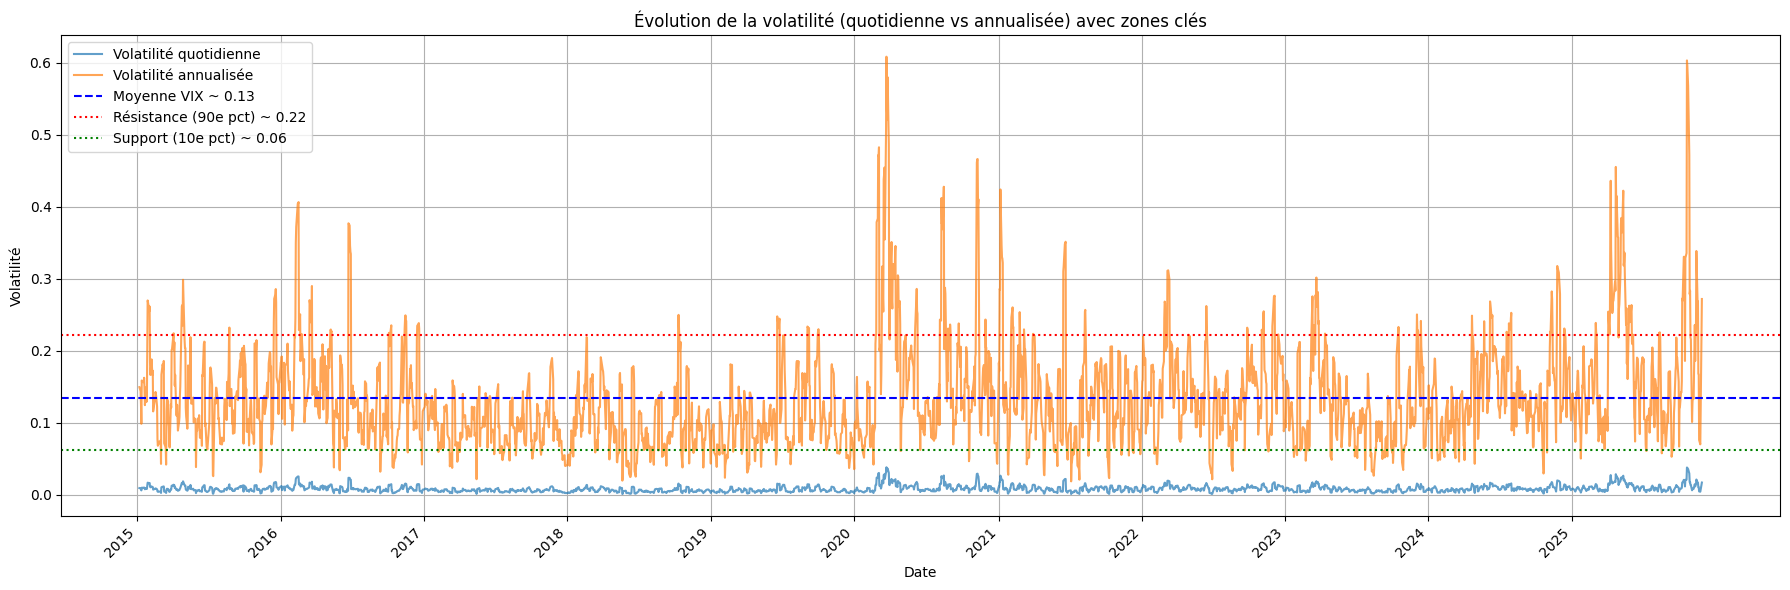

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(18, 6))

# Volatilités
gold['volatilite'].plot(label='Volatilité quotidienne', alpha=0.7)
gold['volatilite_annuelle'].plot(label='Volatilité annualisée', alpha=0.7)

# Moyenne de la volatilité annualisée (notre "VIX maison")
moyenne_vol = gold['volatilite_annuelle'].mean()
plt.axhline(moyenne_vol, color='blue', linestyle='--', label=f'Moyenne VIX ~ {moyenne_vol:.2f}')

# Support / Résistance sur la volatilité annualisée
resistance = gold['volatilite_annuelle'].quantile(0.90)
support = gold['volatilite_annuelle'].quantile(0.10)

plt.axhline(resistance, color='red', linestyle=':', label=f'Résistance (90e pct) ~ {resistance:.2f}')
plt.axhline(support, color='green', linestyle=':', label=f'Support (10e pct) ~ {support:.2f}')

# Titre et légende
plt.title('Évolution de la volatilité (quotidienne vs annualisée) avec zones clés')
plt.xlabel('Date')
plt.ylabel('Volatilité')
plt.legend()

# Étaler l'axe des dates pour voir année par année
plt.xticks(rotation=45)
plt.grid(True)

# Adapter les ticks de l'axe X pour affichage par année
years = gold.index.year.unique()
plt.xticks(
    ticks=[gold.index[gold.index.year == y][0] for y in years],
    labels=[str(y) for y in years]
)

plt.tight_layout()
plt.show()


In [ ]:
pip install arch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 40.9 MB/s eta 0:00:00


In [ ]:
from arch import arch_model
import numpy as np

# Supposons que gold['log_return'] est déjà calculé
log_returns = gold['log_return'].dropna()

# Étape 1 : Mise à l’échelle (évite les warnings et améliore la convergence)
log_returns_scaled = log_returns * 100

# Étape 2 : Modèle GARCH(1,1)
model = arch_model(log_returns_scaled, vol='Garch', p=1, q=1)

# Étape 3 : Entraînement
model_fitted = model.fit(disp='off')

# Étape 4 : Prévision sur 5 jours
forecast = model_fitted.forecast(horizon=5)

# Étape 5 : Extraction de la variance prédite
forecasted_variance_scaled = forecast.variance.iloc[-1]  # Variance à t+1, t+2, ..., t+5

# Étape 6 : Revenir à l’échelle d'origine
forecasted_volatility_real = np.sqrt(forecasted_variance_scaled) / 100

# Étape 7 : Conversion en %
forecasted_vol_pct = forecasted_volatility_real * 100

# Affichage clair avec les dates futures
import pandas as pd
last_date = gold.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=5, freq='B')  # B = jours ouvrés

df_forecast = pd.DataFrame({
    'Date': future_dates,
    'Volatilite_Predite_%': forecasted_vol_pct.values
}).set_index('Date')

print(df_forecast)


            Volatilite_Predite_%
Date                            
2025-12-01              1.508765
2025-12-02              1.499413
2025-12-03              1.490199
2025-12-04              1.481121
2025-12-05              1.472179


In [ ]:
# Dernier prix connu
dernier_prix = gold['Close'].iloc[-1]

# Volatilité prévue pour demain (h.1), convertie en float
vol_jour = forecasted_vol_pct.iloc[0] / 100  # car Series indexée par Date

# Intervalle de prix prévu (±1 écart-type)
prix_min = dernier_prix * (1 - vol_jour)
prix_max = dernier_prix * (1 + vol_jour)

print(f"Intervalle de prix attendu pour demain : [{prix_min:.2f}, {prix_max:.2f} , {dernier_prix:.2f}]")


Intervalle de prix attendu pour demain : [4190.70, 4319.10 , 4254.90]


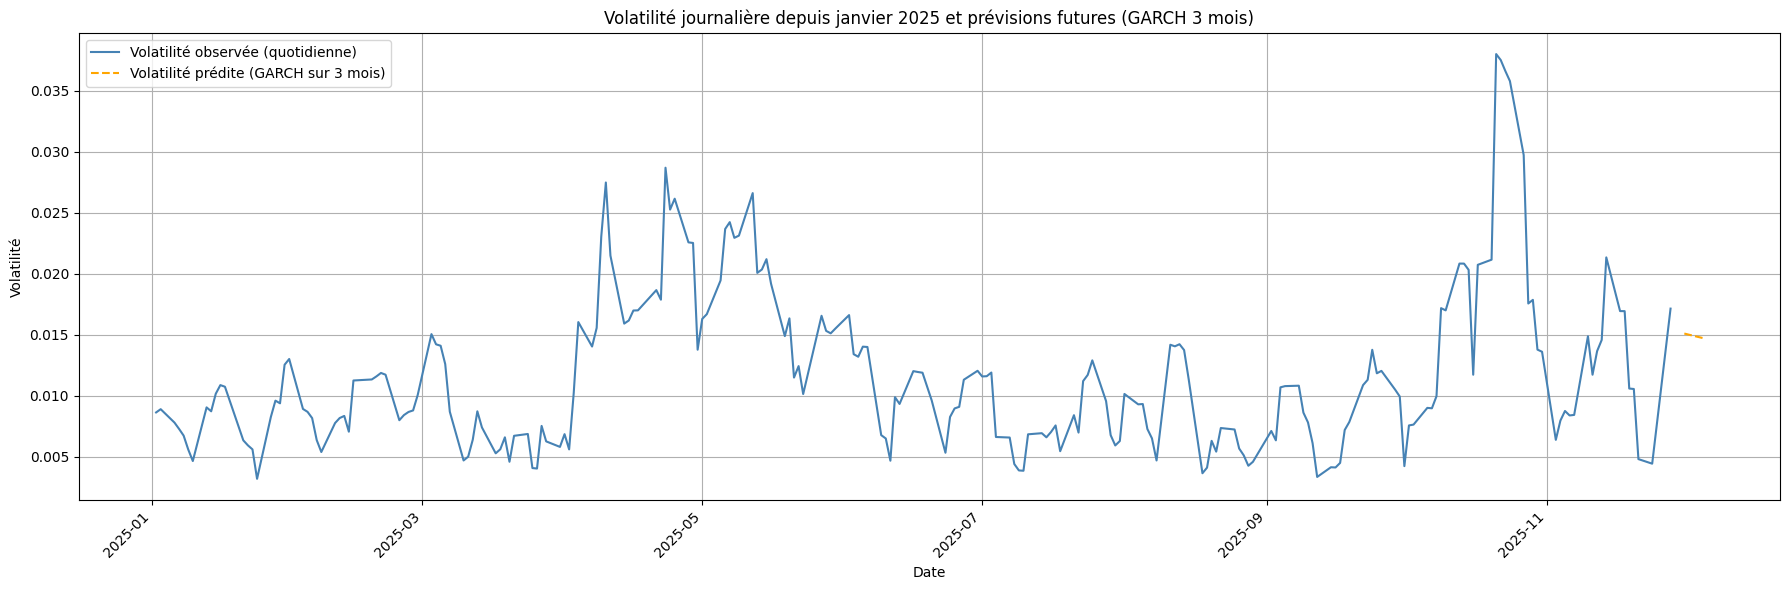

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Sélection des données observées depuis janvier 2025
vol_obs_2025 = gold.loc['2025-01-01':, 'volatilite']

# Prévisions sur 3 mois (df_forecast déjà généré avec horizon mis à jour)
df_forecast['Volatilite_Predite'] = df_forecast['Volatilite_Predite_%'] / 100

# Tracé
plt.figure(figsize=(18, 6))

# Courbe de la volatilité historique
vol_obs_2025.plot(label="Volatilité observée (quotidienne)", color='steelblue')

# Courbe de la volatilité future prédite
df_forecast['Volatilite_Predite'].plot(label="Volatilité prédite (GARCH sur 3 mois)", color='orange', linestyle='--')

# Esthétique
plt.title("Volatilité journalière depuis janvier 2025 et prévisions futures (GARCH 3 mois)")
plt.xlabel("Date")
plt.ylabel("Volatilité")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
